# **Especialização em Ciência de Dados - INF/UFRGS e SERPRO**
### Disciplina CD003 - Aprendizado Supervisionado - Trabalho Prático Final
#### *Profa. Mariana Recamonde-Mendoza (mrmendoza@inf.ufrgs.br)*

### Grupo:
#### Adan Siston
#### Danilo Freitas
#### Hua Lin Chang
<br> 
---
*Trabalho prático da disciplina CD003 - Aprendizado Supervisionado. Desenvolvimento de um pipeline em Python para fazer um spot-checking de algoritmos de aprendizado supervisionado.*
---

**Base de dados:** "Rental prices in brazil" 

**Disponível em:** https://www.kaggle.com/code/olavomendes/rental-prices-in-brazil/data?select=houses_to_rent_v2.csv

**Descrição da base:**

* city - cidade onde o imóvel está localizado
* area - área da propriedade
* rooms - quantidade de quartos
* bathroom - quantidade de banheiros
* parking spaces - quantidade de vagas de garagem
* floor - andar
* animal - aceita animais?
* furniture - mobiliado?
* hoa - taxa de condomínio
* property tax - IPTU / impostos
* rent amount - valor de locação
* fire insurance - valor de seguro 
* total - valor total

## Objetivo
O problema de interesse a ser resolvido é predizer se o valor total do aluguel de um determinado imóvel é "barato" ou "caro" explorando as características do mesmo, como área, quantidade de quartos, quantidade de banheiros, etc. Na base de dados temos o valor total de aluguel (campo "total (R$)") e com isso serão considerados os seguintes critérios:
 - **Barato**: valor de 0 a X reais.
 - **Caro**: valor acima de X reais.
 
Onde X é o valor da mediana, que divide a amostra em quandidades balanceadas de 'Barato' e 'Caro'.


## Metodologia
Neste notebook faremos uma análise exploratória dos dados, tratamentos necessários e aplicação de 10 modelos de algoritmos de aprendizado supervisionado, sendo:

1. MODELO 1 (KNN - K = 1)
2. MODELO 2 (KNN - K = 3)
3. MODELO 3 (KNN - K = 5)
4. MODELO 4 (Naive Bayes)
5. MODELO 5 (SVM - kernel = linear - C = 0.1)
6. MODELO 6 (SVM - kernel = linear - C = 5)
7. MODELO 7 (Árvore de decisão sem poda)
8. MODELO 8 (Árvore de decisão - Pré-poda - max_depth = 10)
9. MODELO 9 (Árvore de decisão - Pré-poda - min_samples_leaf = 20)
10. MODELO 10 (Árvore de decisão - Pós-poda - ccp_alpha = min)
11. MODELO 11 (Árvore de decisão - Pós-poda - ccp_alpha = max)


Avaliaremos as performances dos algoritmos através das métricas de precisão, acurácia e recall.

Por fim destacaremos os 5 melhores modelos.

## Carregando as bibliotecas necessárias

In [ ]:
# A primeira linha é incluída para gerar os gráficos logo abaixo dos comandos de plot
%matplotlib inline              
import pandas as pd             # biblioteca para análise de dados 
import matplotlib.pyplot as plt # biblioteca para visualização de informações
import seaborn as sns           # biblioteca para visualização de informações
import numpy as np              # biblioteca para operações com arrays multidimensionais
from sklearn.neighbors import KNeighborsClassifier # biblioteca para treinar KNN
from sklearn.naive_bayes import GaussianNB # para treinar NB com dados contínuos
from sklearn.svm import SVC  ## para treinar um SVM
from sklearn.model_selection import train_test_split # para divisão de dados
from sklearn.metrics import confusion_matrix, recall_score, precision_score,accuracy_score,ConfusionMatrixDisplay ## para avaliação dos modelos
sns.set()

##Pré processamento dos dados

### Carga dos dados

In [ ]:
houses = pd.read_csv("https://drive.google.com/uc?export=view&id=1C1eBUC3WW4tEWH4FRDaTOB1cKAw-8oY5")
houses.head()  # para visualizar apenas as 5 primeiras linhas

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836


### Exploração inicial dos dados

In [ ]:
## Características gerais do dataset
print("O conjunto de dados possui {} linhas e {} colunas".format(houses.shape[0], houses.shape[1]))

O conjunto de dados possui 10692 linhas e 13 colunas


In [ ]:
houses.info()
houses.isnull().sum() # verificando valores null

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


city                   0
area                   0
rooms                  0
bathroom               0
parking spaces         0
floor                  0
animal                 0
furniture              0
hoa (R$)               0
rent amount (R$)       0
property tax (R$)      0
fire insurance (R$)    0
total (R$)             0
dtype: int64

### Conversão de variáveis categóricas

In [ ]:
## Encontrar as variáveis categóricas
categorical = [var for var in houses.columns if houses[var].dtype=='O']
print('Existem {} atributos categóricos no conjunto de dados\n'.format(len(categorical)))
print('Os atributos categóricos são :', categorical)

Existem 4 atributos categóricos no conjunto de dados

Os atributos categóricos são : ['city', 'floor', 'animal', 'furniture']


In [ ]:
##Verificar a cardinalidade dos valores categóricos 
for var in categorical:
    print(var, ' contains ', len(houses[var].unique()), ' labels')

city  contains  5  labels
floor  contains  35  labels
animal  contains  2  labels
furniture  contains  2  labels


In [ ]:
#Trocar nome das 5 cidades por [0,1,2,3,4] e converter para int
houses["city"].value_counts()

São Paulo         5887
Rio de Janeiro    1501
Belo Horizonte    1258
Porto Alegre      1193
Campinas           853
Name: city, dtype: int64

In [ ]:
# Base de dados utiliza '-' para representar o térreo, converteremos para 0
houses["floor"].value_counts()

-      2461
1      1081
2       985
3       931
4       748
5       600
6       539
7       497
8       490
9       369
10      357
11      303
12      257
13      200
14      170
15      147
16      109
17       96
18       75
19       53
20       44
21       42
25       25
23       25
22       24
26       20
24       19
27        8
28        6
29        5
32        2
35        1
46        1
301       1
51        1
Name: floor, dtype: int64

In [ ]:
# atributo animal: trocar para [0,1]
houses["animal"].value_counts()

acept        8316
not acept    2376
Name: animal, dtype: int64

In [ ]:
# atributo furniture: trocar para [0,1]
houses["furniture"].value_counts()

not furnished    8086
furnished        2606
Name: furniture, dtype: int64

In [ ]:
cleanup_nums = {"city":     {"São Paulo": 0, "Rio de Janeiro": 1, "Belo Horizonte": 2
                             , "Porto Alegre": 3, "Campinas": 4},
                "floor": {"-": 0},
                "animal": {"acept": 0, "not acept": 1},
                "furniture": {"not furnished": 0, "furnished": 1}}

houses = houses.replace(cleanup_nums)
houses["floor"] = pd.to_numeric(houses["floor"])

houses.head()

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,0,70,2,1,1,7,0,1,2065,3300,211,42,5618
1,0,320,4,4,0,20,0,0,1200,4960,1750,63,7973
2,3,80,1,1,1,6,0,0,1000,2800,0,41,3841
3,3,51,2,1,0,2,0,0,270,1112,22,17,1421
4,0,25,1,1,0,1,1,0,0,800,25,11,836


### Removendo outliers

In [ ]:
coluna_outliers = ['area', 'hoa (R$)', 'rent amount (R$)', 'property tax (R$)', 'total (R$)']
print("Antes: ", houses.shape)

Q1 = houses[coluna_outliers].quantile(0.25)
Q3 = houses[coluna_outliers].quantile(0.75)
IQR = Q3 - Q1

houses = houses[~((houses[coluna_outliers] < (Q1 - 1.5 * IQR)) |(houses[coluna_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]
houses_mask = houses['floor']!=301
houses = houses[houses_mask]
print("Depois: ", houses.shape)

Antes:  (10692, 13)
Depois:  (8915, 13)


### Exploração dos dados pós remoção dos outliers

In [ ]:
houses.describe().T
#houses.drop(['total (R$)'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
city,8915.0,1.131127,1.387050,0.0,0.0,0.0,2.0,4.0
area,8915.0,100.846439,70.263079,11.0,50.0,77.0,130.0,367.0
rooms,8915.0,2.257768,1.022720,1.0,1.0,2.0,3.0,10.0
bathroom,8915.0,1.849131,1.040038,1.0,1.0,2.0,2.0,7.0
parking spaces,8915.0,1.226024,1.217052,0.0,0.0,1.0,2.0,10.0
floor,8915.0,4.964105,5.142686,0.0,1.0,3.0,8.0,51.0
animal,8915.0,0.232978,0.422752,0.0,0.0,0.0,0.0,1.0
furniture,8915.0,0.232305,0.422326,0.0,0.0,0.0,0.0,1.0
hoa (R$),8915.0,669.495345,626.849736,0.0,200.0,501.0,980.0,2800.0
rent amount (R$),8915.0,2831.980482,1955.806471,450.0,1400.0,2200.0,3600.0,10200.0


### Exploração visual dos dados

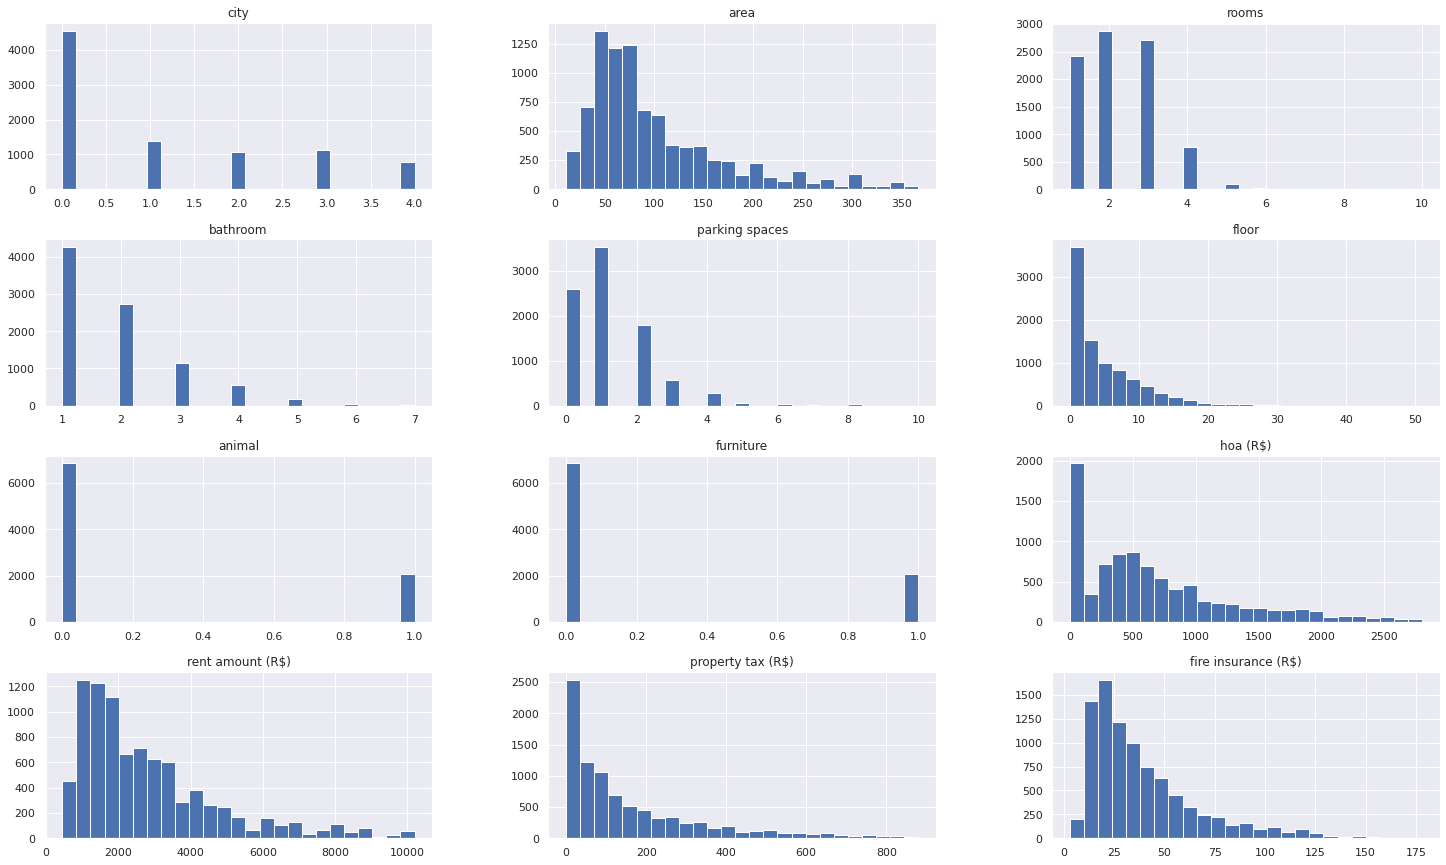

In [ ]:
houses.drop(['total (R$)'],axis=1).hist(bins=25, figsize=(25,15))
plt.show()

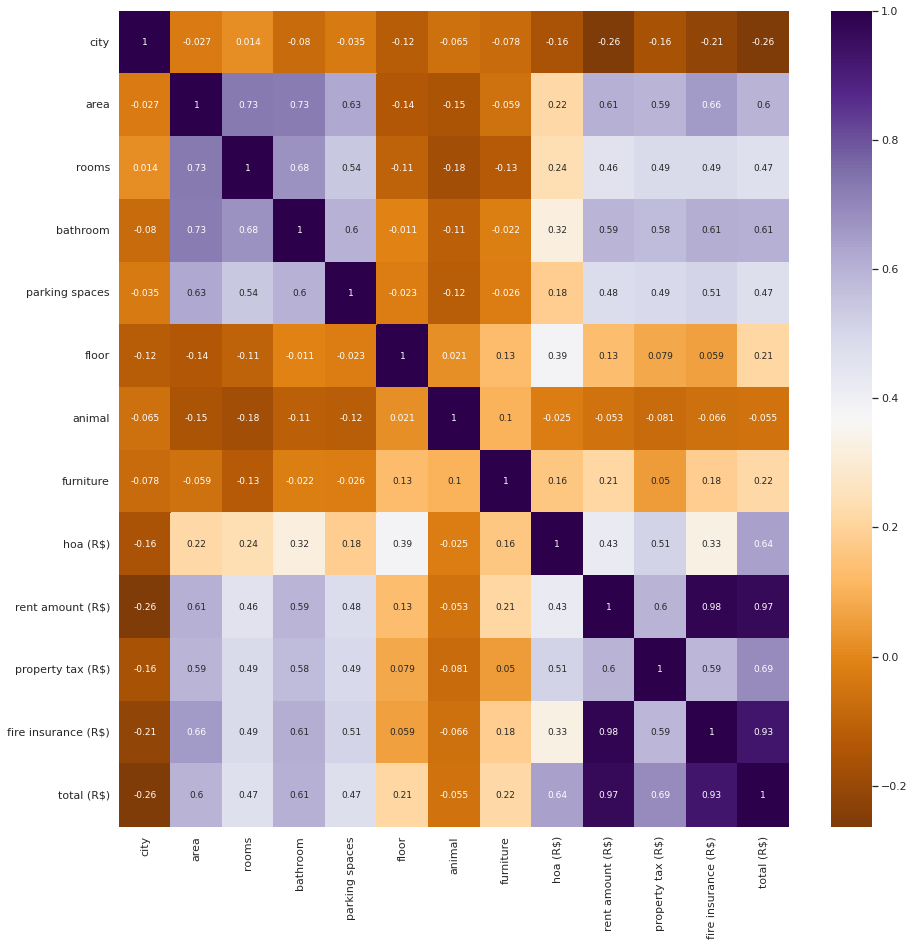

In [ ]:
#Correlação entre atributos numéricos
plt.figure(figsize=(15,15))
sns.heatmap(houses.corr(), annot=True, cmap="PuOr", annot_kws={"size": 9})
plt.show()

## Definição de negócio

*   Classificação de imóveis em baratos (valor 0) e caros (valor 1)
*   Remoção do atributo 'fire insurance' da análise por ter alta correlação com 'rent amount' (correlação de 0.98)
*   Remoção dos atributos 'rent amount', 'hoa' e 'property tax', visto que o atributo de negócio que será previsto pelo modelo é derivado da somas desses atributos. Verificamos que a presença desses atributos influenciava no aumento significativo das métricas de avaliação.



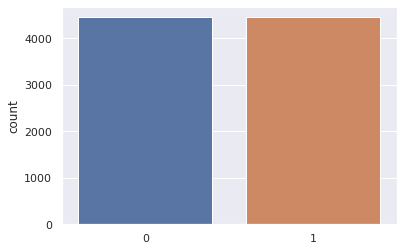

In [ ]:
## Separa o dataset em duas variáveis: os atributos/entradas (X) e a classe/saída (y)
## removendo alguns atributos da análise
X = houses.drop(['total (R$)','fire insurance (R$)','rent amount (R$)', 'hoa (R$)', 'property tax (R$)'],axis=1)
y = houses.iloc[:, 12].values

## Sendo 2994 reais a mediana encontrada para o atributo 'total'
## substitui 'Baratos de 0 a 2994 reais' por 0, 'Caros acima de 2994 reais' por 1
y = np.array([0 if y<=2994 else 1 for y in y]) 
sns.countplot(x=y, data=houses)

## Modelos

### Utilitários




Vetor de sementes

Execução de múltiplas repetições do treinamento e validação usando cada algoritmo (6 repetições).


In [ ]:
random_states = [4, 8, 15, 16, 23, 42]

Função para retornar divisões para treino/teste:

In [ ]:
## Importando o método train_test_split da biblioteca scikit-learn, utilizado para aplicação do holdout. 
## Proporção do conjunto de teste em 20%
from sklearn.model_selection import train_test_split

def dados_split(random_state):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=random_state,stratify=y)

  # Normalização de dados
  from sklearn.preprocessing import MinMaxScaler
  ## Estima os parâmetros para normalização a partir dos dados de treino
  scaler = MinMaxScaler()
  scaler.fit(X_train)

  ## Aplica a normalização nos conjuntos de treino (X_train) e teste (X_test)
  X_train = scaler.transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

Função para exibir matriz de confusão:

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score,accuracy_score,ConfusionMatrixDisplay
## Avaliando o desempenho do modelo usando a matriz de confusão, e três métricas 
## de desempenho: acurácia, recall (sensibilidade) e precisão.

def matriz_confusao(y_test, y_pred, modelo):
  cm = confusion_matrix(y_test, y_pred,labels=modelo.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
  disp = disp.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
  plt.grid(False)
  plt.show()

Função

In [ ]:
# Definição da função para gerar um gráfico métrica por iterações
def plot_metrics_vs_iteration(valores_accuracy, valores_recall, valores_precision):
  # drawstyle = 'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'

  iterations = [1, 2, 3, 4, 5, 6]
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel("Iteração")
  ax.set_ylabel("Métricas")
  ax.set_title("Metrics")
  ax.plot(iterations, valores_accuracy, marker="o", label="accuracy")
  ax.plot(iterations, valores_recall, marker="o", label="recall")
  ax.plot(iterations, valores_precision, marker="o", label="precision")
  ax.legend()
  ax.grid()
  plt.show()


### MODELO 1 (KNN - K = 1)



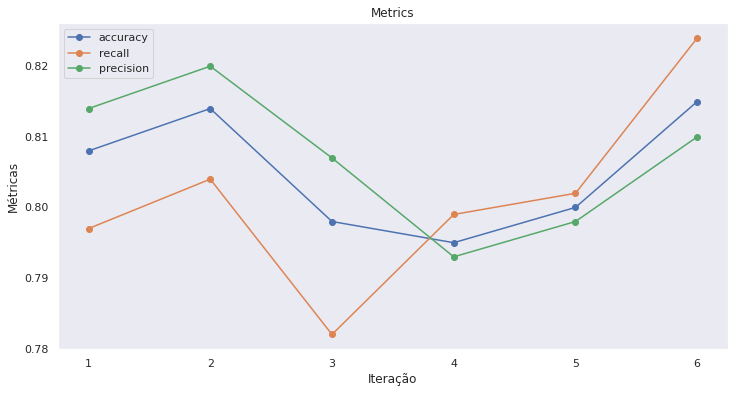

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.805000,0.008532,0.795,0.79850,0.8040,0.8125,0.815
recall,6.0,0.801333,0.013560,0.782,0.79750,0.8005,0.8035,0.824
precision,6.0,0.807000,0.010040,0.793,0.80025,0.8085,0.8130,0.820


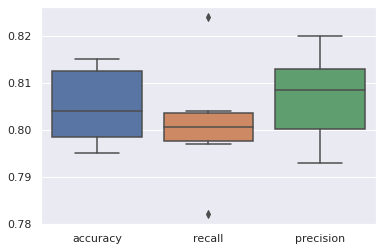

In [ ]:
performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  clf = KNeighborsClassifier(n_neighbors=1,metric='euclidean',weights='uniform')
  clf.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = clf.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])

perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T

  

### MODELO 2 (KNN - K = 3)


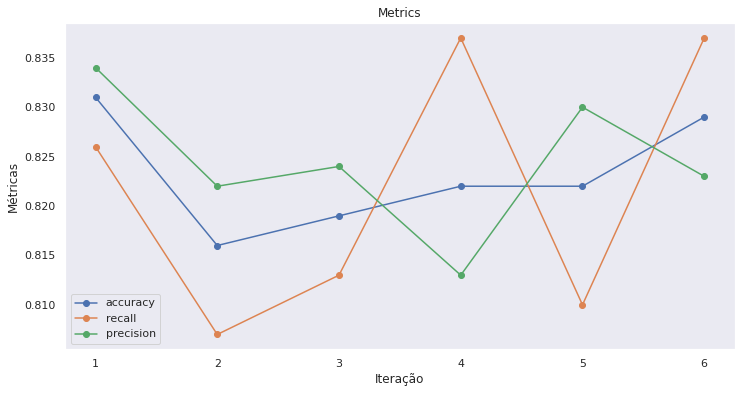

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.823167,0.005776,0.816,0.81975,0.8220,0.82725,0.831
recall,6.0,0.821667,0.013530,0.807,0.81075,0.8195,0.83425,0.837
precision,6.0,0.824333,0.007230,0.813,0.82225,0.8235,0.82850,0.834


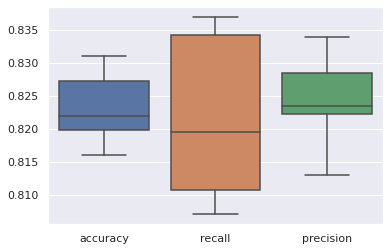

In [ ]:
performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  clf = KNeighborsClassifier(n_neighbors=3,metric='euclidean',weights='uniform')
  clf.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = clf.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])

perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T
  

### MODELO 3 (KNN - K = 5)


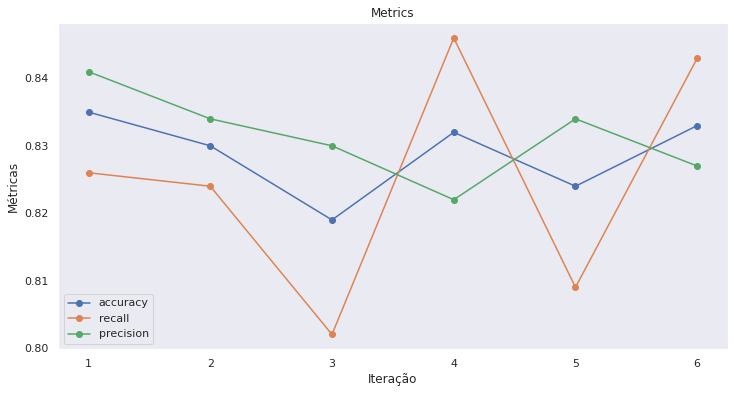

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.828833,0.006113,0.819,0.82550,0.831,0.83275,0.835
recall,6.0,0.825000,0.017618,0.802,0.81275,0.825,0.83875,0.846
precision,6.0,0.831333,0.006563,0.822,0.82775,0.832,0.83400,0.841


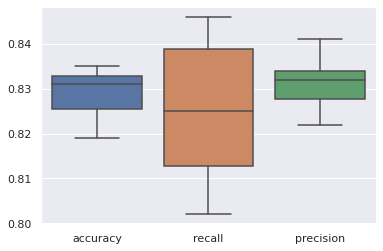

In [ ]:
performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  clf = KNeighborsClassifier(n_neighbors=5,metric='euclidean',weights='uniform')
  clf.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = clf.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])

perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T
  

### MODELO 4 (Naive Bayes)


Vamos treinar um modelo Naive Bayes para dados numéricos, usando o método GaussianNB() pois todos os nossos dados categóricos já foram convertidos para numéricos.

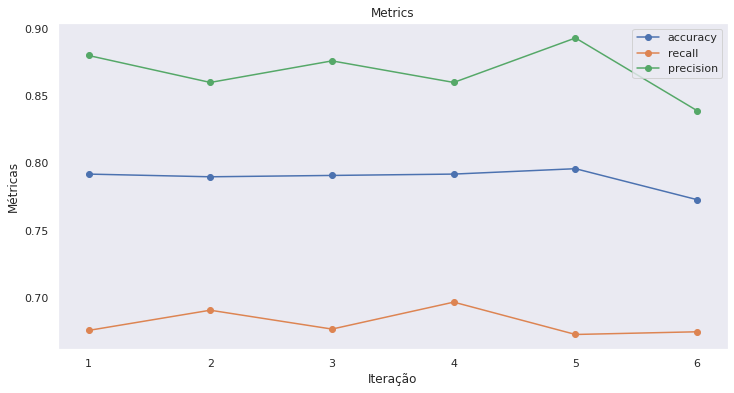

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.7890,0.008099,0.773,0.79025,0.7915,0.7920,0.796
recall,6.0,0.6815,0.009955,0.673,0.67525,0.6765,0.6875,0.697
precision,6.0,0.8680,0.018984,0.839,0.86000,0.8680,0.8790,0.893


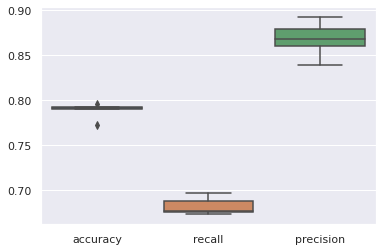

In [ ]:
performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)

  ##--------------------------------------------------------------
  ## Treinando o modelo com GaussianNB
  clf = GaussianNB()
  clf.fit(X_train,y_train)
 
  ##--------------------------------------------------------------
  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = clf.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])

perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T

### MODELO 5 (SVM - kernel = linear - C = 0.1)

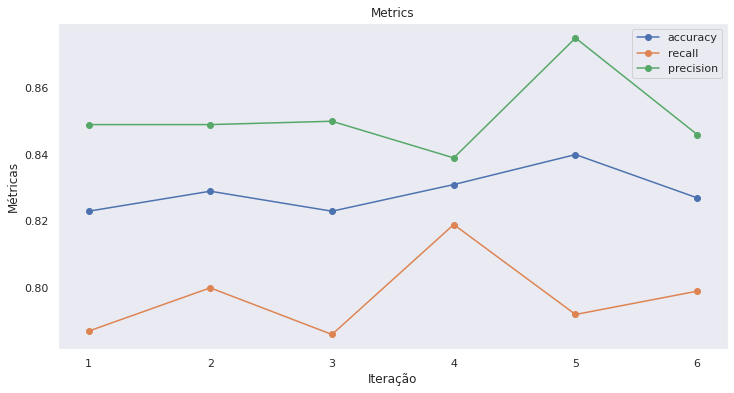

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.828833,0.006338,0.823,0.82400,0.8280,0.83050,0.840
recall,6.0,0.797167,0.012189,0.786,0.78825,0.7955,0.79975,0.819
precision,6.0,0.851333,0.012275,0.839,0.84675,0.8490,0.84975,0.875


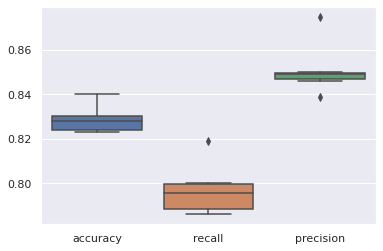

In [ ]:
performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)

  ##--------------------------------------------------------------
  ## Treinando o modelo com hiperparametro C = 0.1
  
  clf = SVC(kernel='linear',C=0.1, class_weight='balanced', random_state=42) 
  clf.fit(X_train, y_train)
   
  ##--------------------------------------------------------------
  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = clf.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])

perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T

### MODELO 6 (SVM - kernel = linear - C = 5)

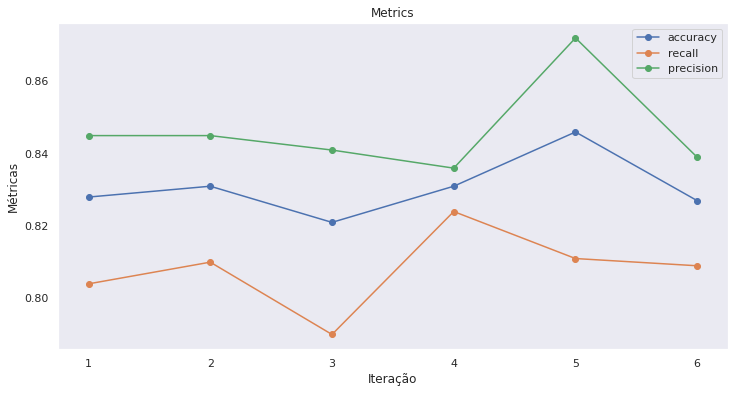

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.830667,0.008359,0.821,0.82725,0.8295,0.83100,0.846
recall,6.0,0.808000,0.011045,0.790,0.80525,0.8095,0.81075,0.824
precision,6.0,0.846333,0.013049,0.836,0.83950,0.8430,0.84500,0.872


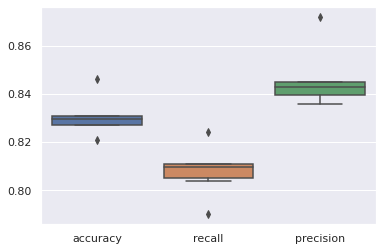

In [ ]:
performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)

  ##--------------------------------------------------------------
  ## Treinando o modelo com hiperparametro C = 5
  
  clf = SVC(kernel='linear',C=5, class_weight='balanced', random_state=42) 
  clf.fit(X_train, y_train)
   
  ##--------------------------------------------------------------
  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = clf.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])

perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T

### MODELO 7 (Árvore de decisão sem poda)


O primeiro modelo utilizando Árvore de decisão será feito sem nenhum ajuste, para que ele sirva de baseline para os que virão a seguir.


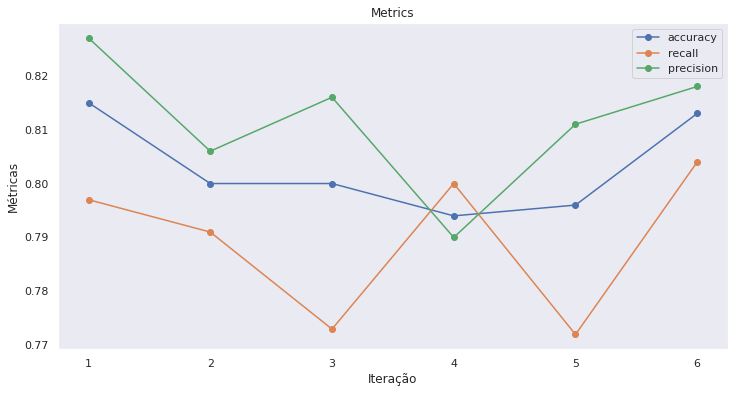

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.803000,0.008854,0.794,0.79700,0.8000,0.80975,0.815
recall,6.0,0.789500,0.013838,0.772,0.77750,0.7940,0.79925,0.804
precision,6.0,0.811333,0.012612,0.790,0.80725,0.8135,0.81750,0.827


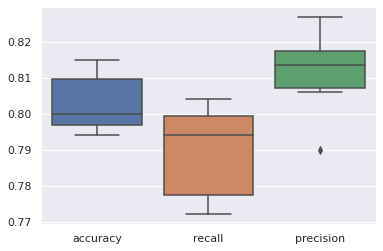

In [ ]:
# Árvore de decisão com configurações padrão
from sklearn.tree import DecisionTreeClassifier


performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  dtStd = DecisionTreeClassifier(random_state=0)
  dtStd.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = dtStd.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])


perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T

In [ ]:
#Estatísticas gerais dos modelos acima
perf_df.drop(['iteration'],axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.803000,0.008854,0.794,0.79700,0.8000,0.80975,0.815
recall,6.0,0.789500,0.013838,0.772,0.77750,0.7940,0.79925,0.804
precision,6.0,0.811333,0.012612,0.790,0.80725,0.8135,0.81750,0.827


### MODELO 8 (Árvore de decisão - Pré-poda - max_depth = 10)

- Árvore de decisão com Pré-poda utilizando os hiperparâmetros max_depth e min_samples_leaf.

- **max_depth** 

A árvore abaixo passará pela pré poda de acordo com os valores atribuídos ao hiperparâmetro max_depth.

Previamente testamos alguns valores deste hiperparâmetro para todas as seis divisões de teste. Os valores testados foram: 1, 3, 5, 10 e 20. 

Abaixo segue a demonstração do valor que apresentou o melhor resultado.


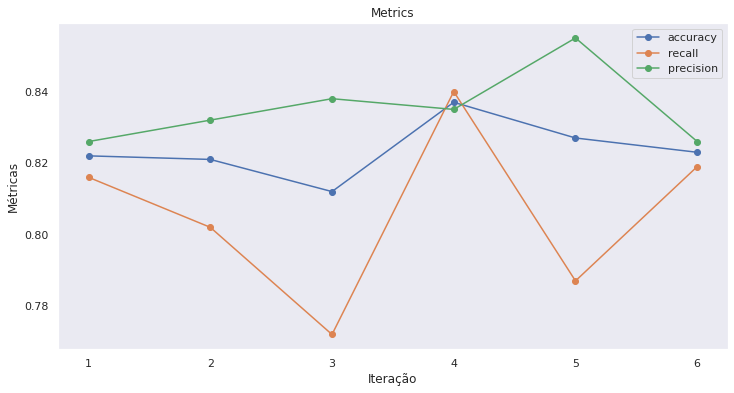

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.823667,0.008189,0.812,0.82125,0.8225,0.82600,0.837
recall,6.0,0.806000,0.024323,0.772,0.79075,0.8090,0.81825,0.840
precision,6.0,0.835333,0.010764,0.826,0.82750,0.8335,0.83725,0.855


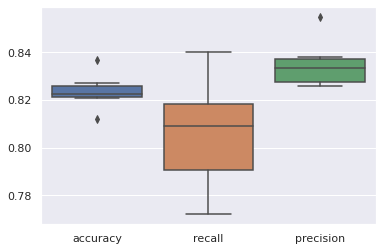

In [ ]:
# Árvore de decisão de decisão com pré poda utilizando max_depth = 10

performance = []
max_depth = 10
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  dtStd = DecisionTreeClassifier(random_state=0,max_depth = max_depth)
  dtStd.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = dtStd.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])


perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T




### MODELO 9 (Árvore de decisão - Pré-poda - min_samples_leaf = 20)

- min_samples_leaf

A árvore abaixo passará pela pré poda de acordo com os valores atribuídos ao hiperparâmetro min_samples_leaf.

Previamente testamos alguns valores deste hiperparâmetro para todas as seis divisões de teste. Os valores testados foram: 1, 5, 10, 20, 50 e 100.

Abaixo segue a demonstração do valor que apresentou o melhor resultado.

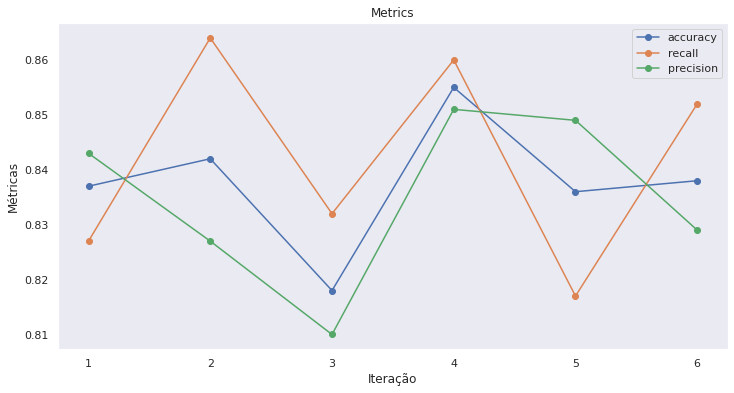

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.837667,0.011911,0.818,0.83625,0.8375,0.8410,0.855
recall,6.0,0.842000,0.019277,0.817,0.82825,0.8420,0.8580,0.864
precision,6.0,0.834833,0.015753,0.810,0.82750,0.8360,0.8475,0.851


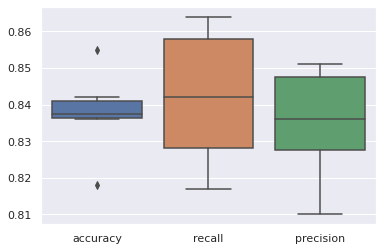

In [ ]:
# Árvore de decisão de decisão com pré poda utilizando min_samples_leaf

min_samples_leaf = 20
performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  dtStd = DecisionTreeClassifier(random_state=0,min_samples_leaf = min_samples_leaf)
  dtStd.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = dtStd.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)

  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])


perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T



### MODELO 10 (Árvore de decisão - Pós-poda - ccp_alpha = min)



- Árvore de decisão com Pré-poda utilizando o hiperparâmetro ccp_alpha (mínimo).



- **ccp_alpha** (Cost Complexity Pruning- Alpha)

Obtenção de valores a serem testados.

Iremos testar alguns valores de ccp_alpha de acordo com o retornado pela função cost_complexity_pruning_path para encontrarmos os valores mínimos e máximos que serão avaliados.



In [ ]:
import numpy

vet_alphas = []
i = 0
for random_state in random_states:
  i += 1
  
  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  dtStd = DecisionTreeClassifier(random_state=0)
  path = dtStd.cost_complexity_pruning_path(X_train, y_train)
  ccp_alphas, impurities = path.ccp_alphas, path.impurities
  alphas = []
  alphas = [np.quantile(ccp_alphas, .25), np.quantile(ccp_alphas, .50), 
            np.quantile(ccp_alphas, .75), np.quantile(ccp_alphas, .100),
            np.mean(ccp_alphas)]
  vet_alphas = numpy.append(vet_alphas, alphas)

# uma solução para diminuir o número de alphas é simplesmente adicionar todos em um único vetor
# e extrair os 5 valores a serem utilizados desse vetor.

print('vet_alphas', vet_alphas)
print('vet_alphas', len(vet_alphas))
min_val = np.min(vet_alphas)
max_val = np.max(vet_alphas)
print('Mínimo', min_val)
print('Máximo', max_val)

vet_alphas [8.74541424e-05 1.26191812e-04 2.03517388e-04 4.67377080e-05
 5.71389532e-04 8.72410925e-05 1.26191812e-04 2.10319686e-04
 4.67377080e-05 5.70450180e-04 8.62849994e-05 1.27466476e-04
 2.02841074e-04 4.67377080e-05 5.80623718e-04 8.92525470e-05
 1.26191812e-04 2.06331178e-04 4.67377080e-05 5.64334981e-04
 9.23492061e-05 1.26191812e-04 2.10319686e-04 4.67377080e-05
 6.00947709e-04 8.58274274e-05 1.24887503e-04 2.07429918e-04
 4.67377080e-05 5.81214160e-04]
vet_alphas 30
Mínimo 4.6737707982800515e-05
Máximo 0.000600947708697415


- **ccp_alpha Mínimo**

A árvore abaixo passará pela pós poda de acordo com o valor mínimo obtido no passo anterior.


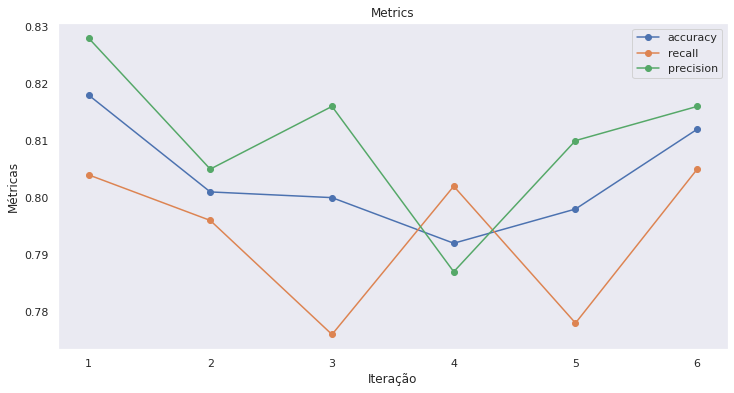

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.803500,0.009628,0.792,0.79850,0.8005,0.80925,0.818
recall,6.0,0.793500,0.013172,0.776,0.78250,0.7990,0.80350,0.805
precision,6.0,0.810333,0.013779,0.787,0.80625,0.8130,0.81600,0.828


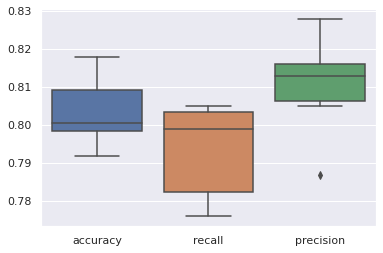

In [ ]:
# Com os valores de alpha obtidos iremos verificar a performance de cada um, 
# sempre respeitando a ordem em que foram criados para cada partição de dados.


performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  dtStd = DecisionTreeClassifier(random_state=0, ccp_alpha = min_val)
  dtStd.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = dtStd.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)


  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])


perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T


### MODELO 11 (Árvore de decisão - Pós-poda - ccp_alpha = max)


- Árvore de decisão com Pré-poda utilizando o hiperparâmetro ccp_alpha (máximo).


- **ccp_alpha Máximo**

A árvore abaixo passará pela pós poda de acordo com o valor máximo obtido no passo anterior.


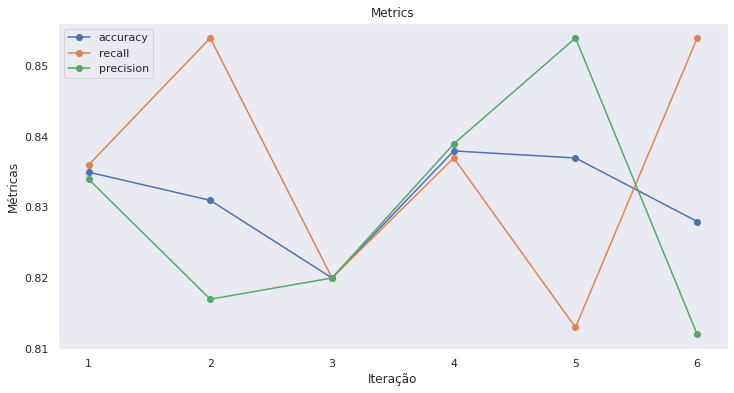

,count,mean,std,min,25%,50%,75%,max
accuracy,6.0,0.831500,0.006775,0.820,0.82875,0.8330,0.83650,0.838
recall,6.0,0.835667,0.016931,0.813,0.82400,0.8365,0.84975,0.854
precision,6.0,0.829333,0.015895,0.812,0.81775,0.8270,0.83775,0.854


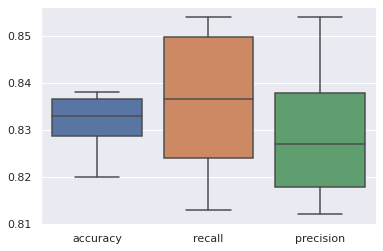

In [ ]:
# Com os valores de alpha obtidos iremos verificar a performance de cada um, 
# sempre respeitando a ordem em que foram criados para cada partição de dados.


performance = []
i=0
for random_state in random_states:
  i += 1

  # split
  X_train, X_test, y_train, y_test = dados_split(random_state)
  
  # definição do modelo
  dtStd = DecisionTreeClassifier(random_state=0, ccp_alpha = max_val)
  dtStd.fit(X_train, y_train)

  ## Aplica o modelo treinado para prever a saída dos dados de teste
  y_pred = dtStd.predict(X_test)

  # exibe matriz de confusão para cada iteração
  # matriz_confusao(y_test, y_pred, clf)


  accuracy = round(accuracy_score(y_test, y_pred),3)
  recall = round(recall_score(y_test, y_pred),3)
  precision = round(precision_score(y_test, y_pred),3)
  performance.append([i,accuracy,recall,precision])


perf_df = pd.DataFrame(performance, columns=['iteration','accuracy','recall','precision'])
plot_metrics_vs_iteration(perf_df['accuracy'].to_numpy(), perf_df['recall'].to_numpy(), perf_df['precision'].to_numpy())
ax = sns.boxplot(data=perf_df.drop(['iteration'],axis=1))
perf_df.drop(['iteration'],axis=1).describe().T


## Resultados
 
Visualizando os dados das métricas de todos os modelos em conjunto.

|                                                                  | accuracy |          |       |       | recall   |          |       |       | precision |          |       |       |
|------------------------------------------------------------------|----------|----------|-------|-------|----------|----------|-------|-------|-----------|----------|-------|-------|
|                                                                  | mean     | std      | min   | max   | mean     | std      | min   | max   | mean      | std      | min   | max   |
| MODELO 01 (KNN - K = 1)                                          | 0,805    | 0,008532 | 0,795 | 0,815 | 0,801333 | 0,01356  | 0,782 | 0,824 | 0,807     | 0,01004  | 0,793 | 0,82  |
| MODELO 02 (KNN - K = 3)                                          | 0,823167 | 0,005776 | 0,816 | 0,831 | 0,821667 | 0,01353  | 0,807 | 0,837 | 0,824333  | 0,00723  | 0,813 | 0,834 |
| MODELO 03 (KNN - K = 5)                                          | 0,828833 | 0,006113 | 0,819 | 0,835 | 0,825    | 0,017618 | 0,802 | 0,846 | 0,831333  | 0,006563 | 0,822 | 0,841 |
| MODELO 04 (Naive Bayes)                                          | 0,789    | 0,008099 | 0,773 | 0,796 | 0,6815   | 0,009955 | 0,673 | 0,697 | 0,868     | 0,018984 | 0,839 | 0,893 |
| MODELO 05 (SVM - kernel = linear - C = 0.1)                      | 0,828833 | 0,006338 | 0,823 | 0,84  | 0,797167 | 0,012189 | 0,786 | 0,819 | 0,851333  | 0,012275 | 0,839 | 0,875 |
| MODELO 06 (SVM - kernel = linear - C = 5)                        | 0,830667 | 0,008359 | 0,821 | 0,846 | 0,808    | 0,011045 | 0,79  | 0,824 | 0,846333  | 0,013049 | 0,836 | 0,872 |
| MODELO 07 (Árvore de decisão sem poda)                           | 0,803    | 0,008854 | 0,794 | 0,815 | 0,7895   | 0,013838 | 0,772 | 0,804 | 0,811333  | 0,012612 | 0,79  | 0,827 |
| MODELO 08 (Árvore de decisão - Pré-poda - max_depth = 10)        | 0,823667 | 0,008189 | 0,812 | 0,837 | 0,806    | 0,024323 | 0,772 | 0,84  | 0,835333  | 0,010764 | 0,826 | 0,855 |
| MODELO 09 (Árvore de decisão - Pré-poda - min_samples_leaf = 20) | 0,837667 | 0,011911 | 0,818 | 0,855 | 0,842    | 0,019277 | 0,817 | 0,864 | 0,834833  | 0,015753 | 0,81  | 0,851 |
| MODELO 10 (Árvore de decisão - Pós-poda - ccp_alpha = min)       | 0,8035   | 0,009628 | 0,792 | 0,818 | 0,7935   | 0,013172 | 0,776 | 0,805 | 0,810333  | 0,013779 | 0,787 | 0,828 |
| MODELO 11 (Árvore de decisão - Pós-poda - ccp_alpha = max)       | 0,8315   | 0,006775 | 0,82  | 0,838 | 0,835667 | 0,016931 | 0,813 | 0,854 | 0,829333  | 0,015895 | 0,812 | 0,854 |




Modelos ordenados pela 'accuracy'

| Modelo                                                           | accuracy |
|------------------------------------------------------------------|----------|
| MODELO 09 (Árvore de decisão - Pré-poda - min_samples_leaf = 20) | 0,837667 |
| MODELO 11 (Árvore de decisão - Pós-poda - ccp_alpha = max)       | 0,8315   |
| MODELO 06 (SVM - kernel = linear - C = 5)                        | 0,830667 |
| MODELO 03 (KNN - K = 5)                                          | 0,828833 |
| MODELO 05 (SVM - kernel = linear - C = 0.1)                      | 0,828833 |
| MODELO 08 (Árvore de decisão - Pré-poda - max_depth = 10)        | 0,823667 |
| MODELO 02 (KNN - K = 3)                                          | 0,823167 |
| MODELO 01 (KNN - K = 1)                                          | 0,805    |
| MODELO 10 (Árvore de decisão - Pós-poda - ccp_alpha = min)       | 0,8035   |
| MODELO 07 (Árvore de decisão sem poda)                           | 0,803    |
| MODELO 04 (Naive Bayes)                                          | 0,789    |


Modelos ordenados pelo 'recall'

| Modelo                                                           | recall   |
|------------------------------------------------------------------|----------|
| MODELO 09 (Árvore de decisão - Pré-poda - min_samples_leaf = 20) | 0,842    |
| MODELO 11 (Árvore de decisão - Pós-poda - ccp_alpha = max)       | 0,835667 |
| MODELO 03 (KNN - K = 5)                                          | 0,825    |
| MODELO 02 (KNN - K = 3)                                          | 0,821667 |
| MODELO 06 (SVM - kernel = linear - C = 5)                        | 0,808    |
| MODELO 08 (Árvore de decisão - Pré-poda - max_depth = 10)        | 0,806    |
| MODELO 01 (KNN - K = 1)                                          | 0,801333 |
| MODELO 05 (SVM - kernel = linear - C = 0.1)                      | 0,797167 |
| MODELO 10 (Árvore de decisão - Pós-poda - ccp_alpha = min)       | 0,7935   |
| MODELO 07 (Árvore de decisão sem poda)                           | 0,7895   |
| MODELO 04 (Naive Bayes)                                          | 0,6815   |


Modelos ordenados pela 'precision'

| Modelo                                                           | precision |
|------------------------------------------------------------------|-----------|
| MODELO 04 (Naive Bayes)                                          | 0,868     |
| MODELO 05 (SVM - kernel = linear - C = 0.1)                      | 0,851333  |
| MODELO 06 (SVM - kernel = linear - C = 5)                        | 0,846333  |
| MODELO 08 (Árvore de decisão - Pré-poda - max_depth = 10)        | 0,835333  |
| MODELO 09 (Árvore de decisão - Pré-poda - min_samples_leaf = 20) | 0,834833  |
| MODELO 03 (KNN - K = 5)                                          | 0,831333  |
| MODELO 11 (Árvore de decisão - Pós-poda - ccp_alpha = max)       | 0,829333  |
| MODELO 02 (KNN - K = 3)                                          | 0,824333  |
| MODELO 07 (Árvore de decisão sem poda)                           | 0,811333  |
| MODELO 10 (Árvore de decisão - Pós-poda - ccp_alpha = min)       | 0,810333  |
| MODELO 01 (KNN - K = 1)                                          | 0,807     |


## Conclusão